In [1]:
import logging
import warnings
from darts.datasets import AirPassengersDataset
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis, plot_residuals_analysis #,plot_hist
from darts.metrics import mape, mase
from darts.models import (
    NaiveSeasonal,
    NaiveDrift,
    ExponentialSmoothing,
    ARIMA,
    AutoARIMA,
    RegressionEnsembleModel,
    RegressionModel,
    Theta,
    FFT
)
from darts import TimeSeries
from functools import reduce
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import sys
%load_ext autoreload
%autoreload 2
%matplotlib inline


warnings.filterwarnings("ignore")
logging.disable(logging.CRITICAL)


[2021-10-13 09:52:33,625] WARNING | darts.models | Support Facebook Prophet is not available. To enable it, install u8darts[prophet] or u8darts[all].


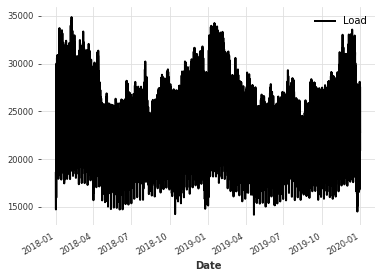

In [2]:
ts60 = pd.read_csv(
    '../../RDN/Load Data (2018-2019)/artifacts/load_60min.csv', index_col=0, parse_dates=True)
load60 = ts60['Load'].dropna()
load60.head()

# series = AirPassengersDataset().load()
# 
series = TimeSeries.from_series(load60)
series.plot()

## Train test split

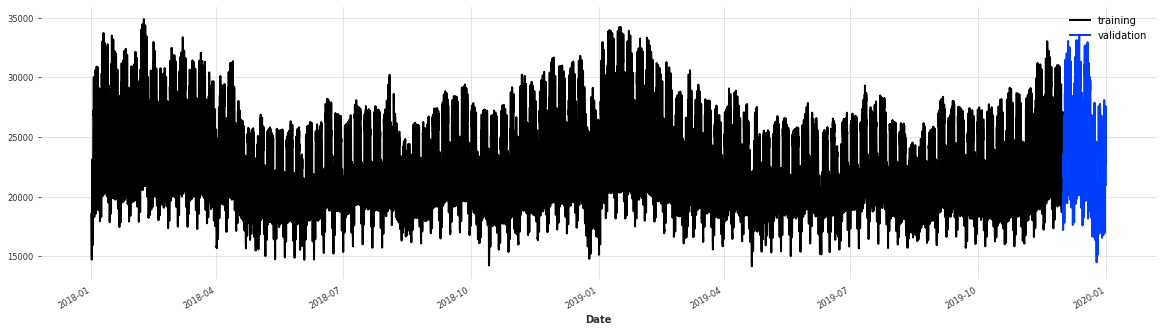

In [3]:
# split
train, val = series.split_before(pd.Timestamp('20191201'))
pretty_train = train.drop_before(pd.Timestamp('20191120'))

# plot
plt.figure(figsize=(20, 5))
train.plot(label='training')
val.plot(label='validation')
plt.legend()


# ACF

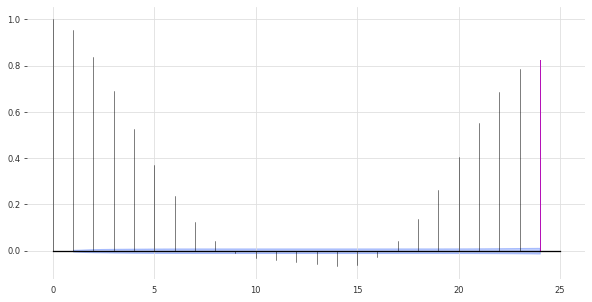

In [4]:
plot_acf(train, m = 24, alpha = .05)

In [71]:
for m in range(2, 7*24):
    is_seasonal, period = check_seasonality(train, m=m, alpha=.05, max_lag=2*7*24)
    if is_seasonal:
        print('There is seasonality of order {}.'.format(period))

There is seasonality of order 24.
There is seasonality of order 48.
There is seasonality of order 72.
There is seasonality of order 96.
There is seasonality of order 120.
There is seasonality of order 144.


## Totally Naive (memory of one past timestep)
Take care! Naive should be updated the same time intervals as the rest of models!! 

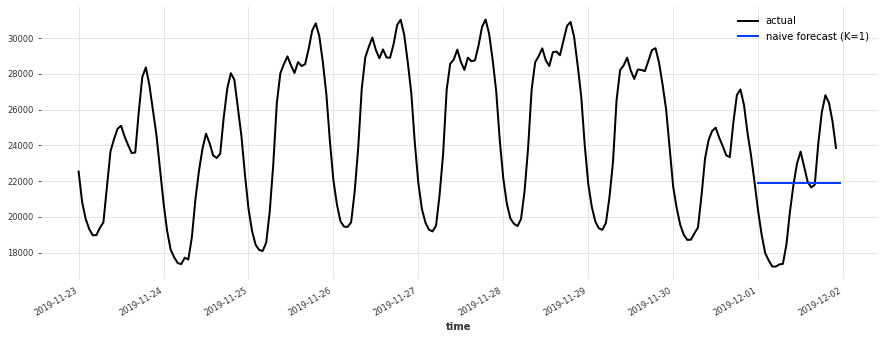

In [4]:
naive_model = NaiveSeasonal(K=1)
naive_model.fit(train)
naive_forecast = naive_model.predict(24)

plt.figure(figsize=(15,5))
series.drop_before(pd.Timestamp(naive_forecast.time_index[-1] - datetime.timedelta(days=9))).drop_after(naive_forecast.time_index[-1]).plot(label='actual')
naive_forecast.plot(label='naive forecast (K=1)')
plt.legend();


## Less Naive (memory all timesteps that form a seasonal period)

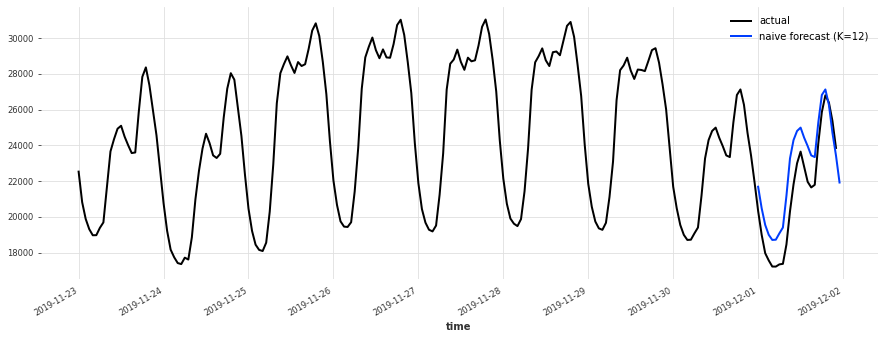

In [5]:
seasonal_model = NaiveSeasonal(K=24)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(24)

plt.figure(figsize=(15, 5))
series.drop_before(pd.Timestamp(seasonal_forecast.time_index[-1] - datetime.timedelta(days=9))).drop_after(seasonal_forecast.time_index[-1]).plot(label='actual')
seasonal_forecast.plot(label='naive forecast (K=12)')
plt.legend()


## Best Naive model. Also adds the trend of our timeseries. in Nester time series even if there is a trend one day ahead is too short-term to let it manifest itself and influence forecasts.

Mean absolute percentage error for the combined naive drift + seasonal: 7.14%.


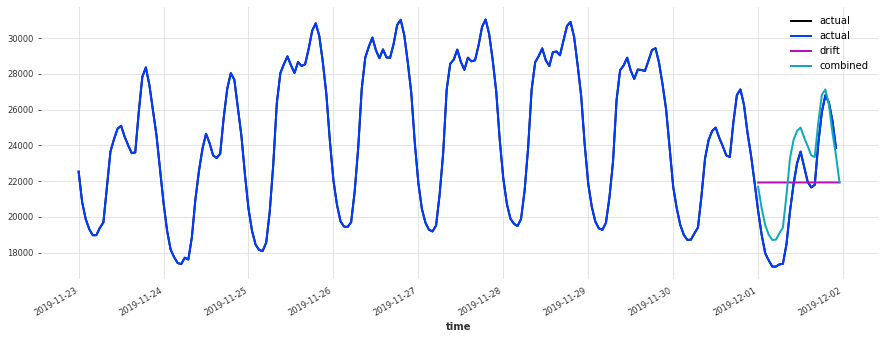

In [6]:
drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(24)

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

plt.figure(figsize=(15, 5))

series.drop_before(pd.Timestamp(combined_forecast.time_index[-1] - datetime.timedelta(days=9))).drop_after(combined_forecast.time_index[-1]).plot(label='actual')
series.drop_before(pd.Timestamp(drift_forecast.time_index[-1] - datetime.timedelta(days=9))).drop_after(drift_forecast.time_index[-1]).plot(label='actual')

drift_forecast.plot(label='drift')
combined_forecast.plot(label='combined')
plt.legend();
print("Mean absolute percentage error for the combined naive drift + seasonal: {:.2f}%.".format(mape(series, combined_forecast)))

## Try more models

In [7]:
def eval_model(model):
    model.fit(train)
    forecast = model.predict(24)
    print('model {} obtains MAPE: {:.2f}%'.format(model, mape(val, forecast)))

eval_model(ExponentialSmoothing())
eval_model(AutoARIMA())
eval_model(Theta())

model Exponential smoothing obtains MAPE: 16.12%
model Auto-ARIMA obtains MAPE: 14.45%
model Theta(2) obtains MAPE: 6.34%


## The Theta method
### Gridsearch

In [11]:
# Search for the best theta parameter, by trying 50 different values
thetas = 2 - np.linspace(-10, 10, 20)

best_mape = float('inf')
best_theta = 0

for theta in thetas:
    model = Theta(theta)
    model.fit(train)
    pred_theta = model.predict(24)
    res = mape(val, pred_theta)

    if res < best_mape:
        best_mape = res
        best_theta = theta


In [12]:
best_theta_model = Theta(best_theta)
best_theta_model.fit(train)
pred_best_theta = best_theta_model.predict(len(val))

print('The MAPE is: {:.2f}, with theta = {}.'.format(mape(val, pred_best_theta), best_theta))

The MAPE is: 10.90, with theta = -0.6315789473684212.


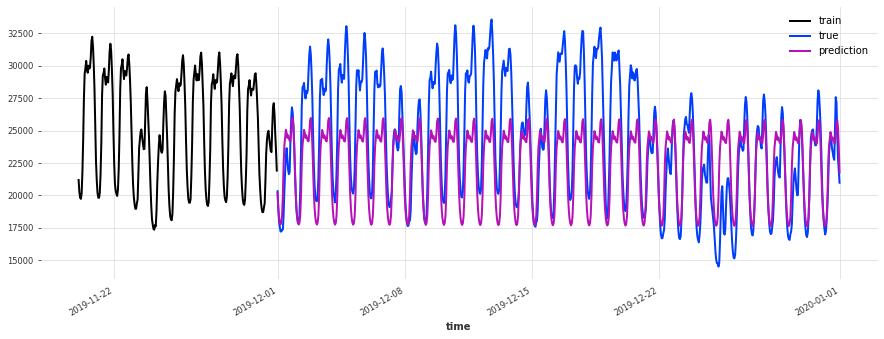

In [13]:
plt.figure(figsize=(15, 5))
pretty_train.plot(label='train')
val.plot(label='true')
pred_best_theta.plot(label='prediction')
plt.legend()

### Backtesting: Simulate historical forecasting

Computes error scores between the historical forecasts the model would have produced with an expanding training window over series and the actual values. To this end, it repeatedly builds a training set from the beginning of series. It trains the current model on the training set, emits a forecast of length equal to forecast_horizon, and then moves the end of the training set forward by stride time steps. A metric (given by the metric function) is then evaluated on the forecast and the actual values. Finally, the method returns a reduction (the mean by default) of all these metric scores.

So at this point we have a model that performs well on our validation set, and that’s good. But, how can we know the performance we would have obtained if we had been using this model historically?

Backtesting simulates predictions that would have been obtained historically with a given model. It can take a while to produce, since the model is re-fit every time the simulated prediction time advances.

Such simulated forecasts are always defined with respect to a forecast horizon, which is the number of time steps that separate the prediction time from the forecast time. In the example below, we simulate forecasts done for 24hours in the future (compared to prediction time).

In [14]:
backtest_first_day = '20191120'
best_theta_model = Theta(best_theta)

raw_errors = best_theta_model.backtest(train, start=pd.Timestamp(backtest_first_day), forecast_horizon=24, stride=1, verbose=True, reduction=None)
# mean_error = best_theta_model.backtest(series, start=pd.Timestamp(dataset_first_day), forecast_horizon=24, verbose=True)
# median_error = best_theta_model.backtest(series, start=pd.Timestamp(dataset_first_day), forecast_horizon=24, reduction=np.median, verbose=True)

print("Average error (MAPE) over all historical forecasts: {}".format(np.mean(raw_errors)))
print("Median error (MAPE) over all historical forecasts: {}".format(np.median(raw_errors)))

# plot_hist(raw_errors, bins=np.arange(0, max(raw_errors), 1), title='Individual backtest error scores (histogram)')

historical_fcast_theta = best_theta_model.historical_forecasts(train, start=pd.Timestamp(backtest_first_day), forecast_horizon=24, stride=1, verbose=True)


  0%|          | 0/241 [00:00<?, ?it/s]

Average error (MAPE) over all historical forecasts: 6.223508896541378
Median error (MAPE) over all historical forecasts: 5.327197970496193


  0%|          | 0/241 [00:00<?, ?it/s]

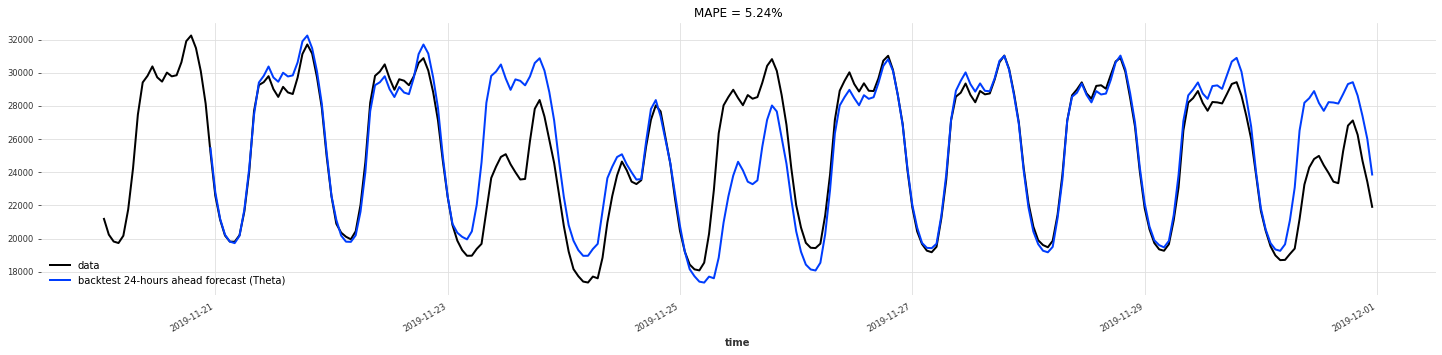

In [15]:
plt.figure(figsize=(25, 5))

pretty_train.plot(label='data')
historical_fcast_theta.plot(label='backtest 24-hours ahead forecast (Theta)')

plt.title('MAPE = {:.2f}%'.format(mape(historical_fcast_theta, train)))
plt.legend()


In [16]:
#plot_residuals_analysis(best_theta_model.residuals(train))

## Try Exponential Smoothing
Exponential smoothing wont work as it requires decomposition to work well.

  0%|          | 0/241 [00:00<?, ?it/s]

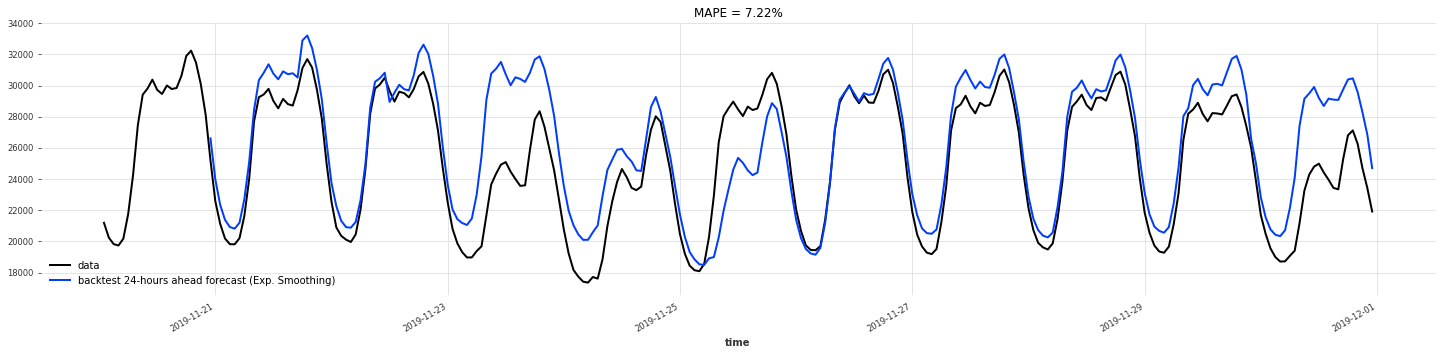

In [17]:
model_es = ExponentialSmoothing()
historical_fcast_es = model_es.historical_forecasts(train, start=pd.Timestamp(backtest_first_day), forecast_horizon=24, verbose=True)

plt.figure(figsize=(25, 5))
pretty_train.plot(label='data')
historical_fcast_es.plot(label='backtest 24-hours ahead forecast (Exp. Smoothing)')
plt.title('MAPE = {:.2f}%'.format(mape(historical_fcast_es, train)))
plt.legend()
plt.show()


In [18]:
# plot_residuals_analysis(model_es.residuals(train))

# Probabilistic Forecasts
Some models can produce probabilistic forecasts. At the time of writing, this is the case for RNNModel, TCNModel, ARIMA and ExponentialSmoothing. For RNNModel and TCNModel (as well as other neural network based models), one has to specify a Likelihood (e.g. darts.utils.likelihood_models.GaussianLikelihood for Gaussian likelihood) - we refer the readers to notebooks 09 and 10 for examples.

For ARIMA and ExponentialSmoothing, one can simply specify a num_samples parameter to the predict() function. The returned TimeSeries will then be composed of num_samples samples describing the distribution of the time series’ values, which can for instance be used to obtain quantiles:

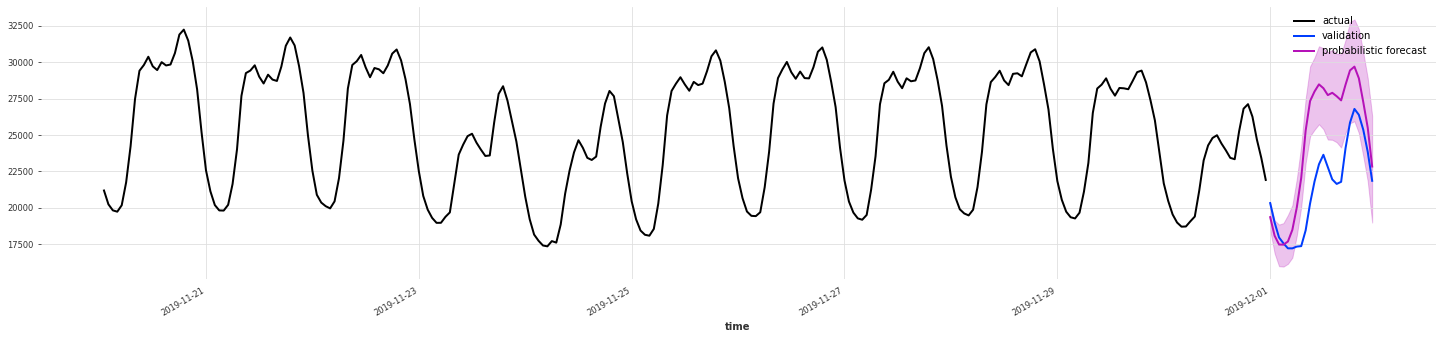

In [10]:
model_es = ExponentialSmoothing()
model_es.fit(train)
probabilistic_forecast = model_es.predict(len(val), num_samples=500)

plt.figure(figsize=(25, 5))
pretty_train.plot(label='actual')
val.plot(label='validation')
probabilistic_forecast.plot(label='probabilistic forecast')
plt.legend()
plt.show()

By default TimeSeries.plot() shows the median as well as the 5th and 95th percentiles (of the marginal distributions, if the TimeSeries is multivariate). It is possible to control this:


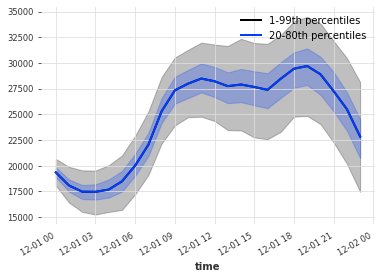

In [ ]:
probabilistic_forecast.plot(low_quantile=0.01, high_quantile=0.99, label='1-99th percentiles')
probabilistic_forecast.plot(low_quantile=0.2, high_quantile=0.8, label='20-80th percentiles')

# Ensembling several predictions
## <font color=red>WOW: ensembling naive model produces a perfect prediction of the validation set !!!!!!!

Ensembling is about combining the forecasts produced by several models, in order to obtain a final – and hopefully better forecast.

RegressionEnsembleModel:
Class for ensemble models using a regression model for ensembling individual models’ predictions. The provided regression model must implement fit() and predict() methods (e.g. scikit-learn regression models). **Note that here the regression model is used to learn how to best ensemble the individual forecasting models’ forecasts. It is not the same usage of regression as in RegressionModel, where the regression model is used to produce forecasts based on the lagged series.**
regression_train_n_points – The number of points to use to train the regression model

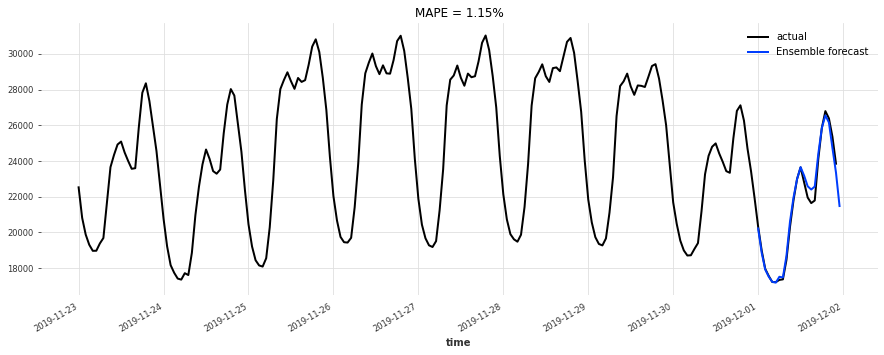

In [19]:
ensemble_model = RegressionEnsembleModel(
    forecasting_models=[NaiveSeasonal(24), NaiveSeasonal(24*7), NaiveDrift()],
    regression_train_n_points=24)

ensemble_model.fit(train)
ensemble_pred = ensemble_model.predict(24)

plt.figure(figsize=(15, 5))
series.drop_before(pd.Timestamp(ensemble_pred.time_index[-1] - datetime.timedelta(days=9))).drop_after(ensemble_pred.time_index[-1]).plot(label='actual')

ensemble_pred.plot(label='Ensemble forecast')
plt.title('MAPE = {:.2f}%'.format(mape(ensemble_pred, val)))
plt.legend()


## WOW

  0%|          | 0/7993 [00:00<?, ?it/s]

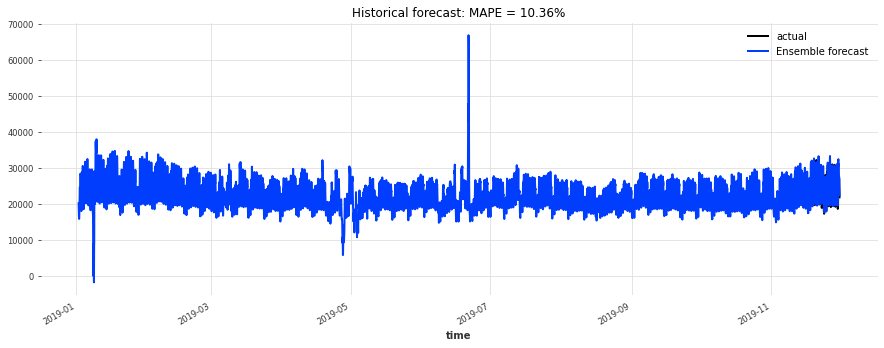

In [13]:
ensemble_pred_hist = ensemble_model.historical_forecasts(train,
                                                         start=pd.Timestamp('20190101'),
                                                         forecast_horizon=24,
                                                         verbose=True)
plt.figure(figsize=(15, 5))
pretty_train.plot(label='actual')
ensemble_pred_hist.plot(label='Ensemble forecast')
plt.title('Historical forecast: MAPE = {:.2f}%'.format(mape(ensemble_pred_hist, train)))
plt.legend()
